### Evasion dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

In [8]:
# configs 
my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

In [9]:
active = pd.read_csv('data/alunos_ativos.csv')
deactive = pd.read_csv('data/alunos_inativos.csv')
history = pd.read_csv('data/historico_escolar.csv')

# Choose what to see 

In [15]:
datasets = [active, deactive]

for i in datasets:
    def_test = i.copy()
    def_test['Data ocorrência']= pd.to_datetime(def_test['Data ocorrência'])
    def_test['Data Nascimento']= pd.to_datetime(def_test['Data Nascimento'])
    def_test['Difference'] = ((def_test['Data ocorrência'] - def_test['Data Nascimento']).dt.days / 365.0)
    i.loc[:,'Idade'] = def_test['Difference']

    
active.head()
active.isnull().sum()
deactive.isnull().sum()
history.isnull().sum()
finished = deactive[deactive['Situação atual'] == 'EXCLUSAO POR CONCLUSAO (FORMADO)']
dropout = deactive[deactive['Situação atual'] != 'EXCLUSAO POR CONCLUSAO (FORMADO)']

In [ ]:
# active.info()
# dropout.info()
# history.info()
# finished.info()

In [16]:
# Normalizing names from Naturalidade column

def normalize_names(text):
    if pd.isnull(text):
        return text
    text = str(text)
    text = unidecode.unidecode(text)
    text = text.lower().strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = text.title()
    return text


## Correcting mispelled cities

In [227]:
corrected_cities = {
    'Barra Do Garcas  Mt': 'Barra Do Garcas',
    'Canabravamg': 'Cana Brava',  
    'Baliza Go' : 'Baliza' ,
    'Rondonopolitano': 'Rondonopolis',
    'Braganca Pa': 'Braganca',
    'Aragarcasgo': 'Aragarcas',
    'Nova Xavantina  Mt': 'Nova Xavantina',
    'BARRA DO GARCAS - MT': 'Barra Do Garcas',
    'alta floresta - MT': 'Alta Floresta',
    'Cuiabamt': 'Cuiaba',
    'Palmitossc': 'Palmitos',
    'Vazante Mg': 'Vazante',
    'Jussarago': 'Jussara',
    'Rio Branco  Mt': 'Rio Branco',
    'Mato Grossointerior': 'Mato Grosso',
    'Chapecosc': 'Chapeco',
    'Agua Boamt': 'Agua Boa',
    'Alta Floresta  Mt': 'Alta Floresta',
    'Sao Joaquim Sc': 'Sao Joaquim',
    'Barra Do Garcas - Mt': 'Barra Do Garcas',
    'ARAGARÇAS': 'Aragarcas',
    'BARRA DO GARÇAS': 'Barra do Garcas'
}
datasets = [deactive, dropout, active, finished]

for df in datasets:
    df.loc[:,'Naturalidade'] = df['Naturalidade'].apply(normalize_names)

    df.loc[:,'Naturalidade']  = df['Naturalidade'].replace(corrected_cities)

## Group comparasion Finished vs Dropout


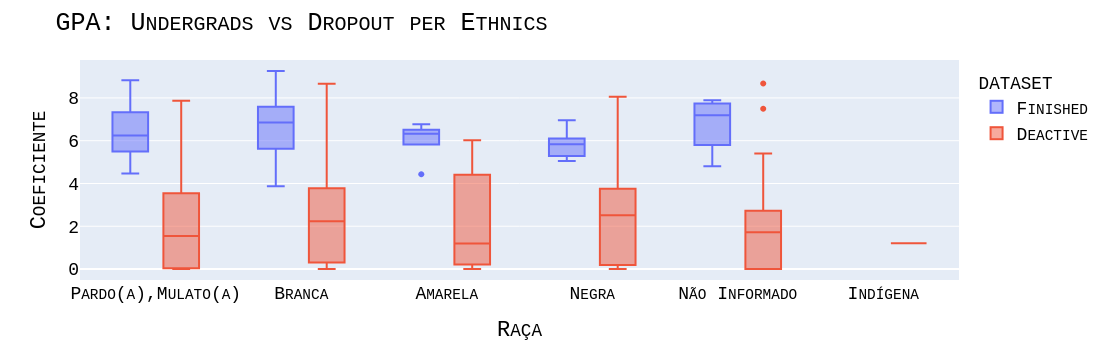

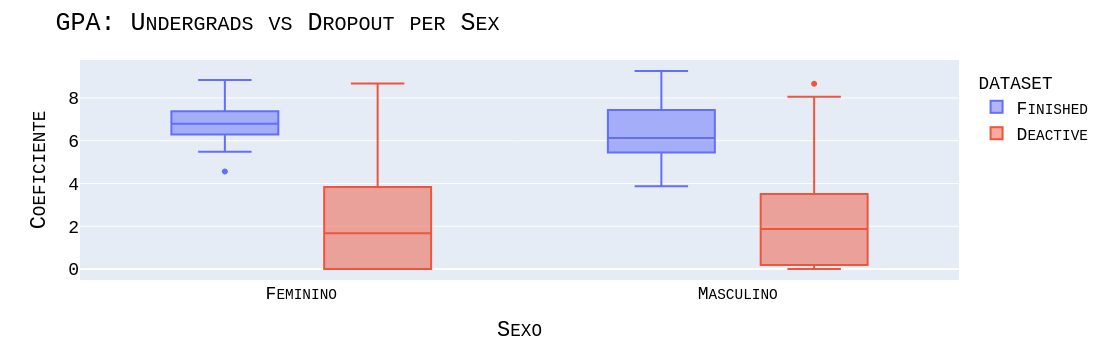

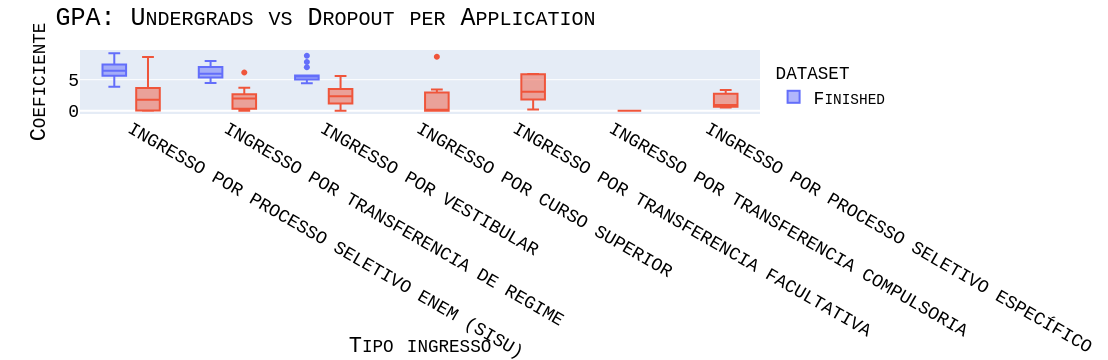

In [117]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

px.box(x, x='Raça', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Ethnics"}, font=my_font).show()
px.box(x, x='Sexo', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Sex"}, font=my_font).show()
px.box(x, x='Tipo ingresso', y='Coeficiente', color='dataset').update_layout(title={"text": "GPA: Undergrads vs Dropout per Application "}, font=my_font).show()


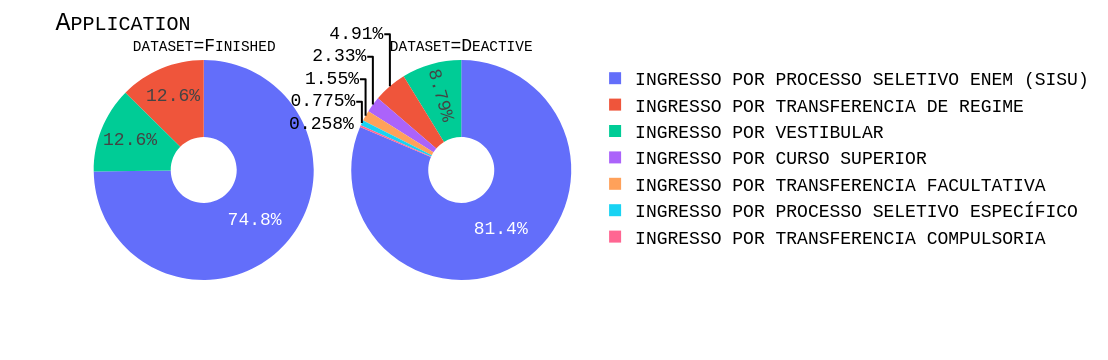

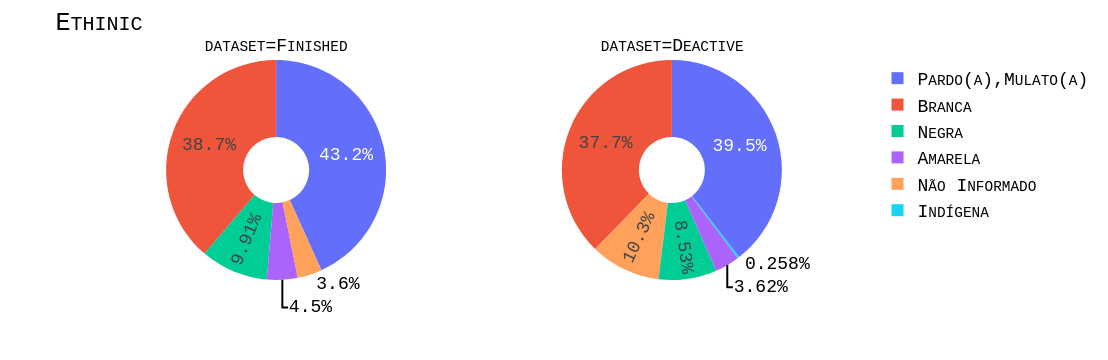

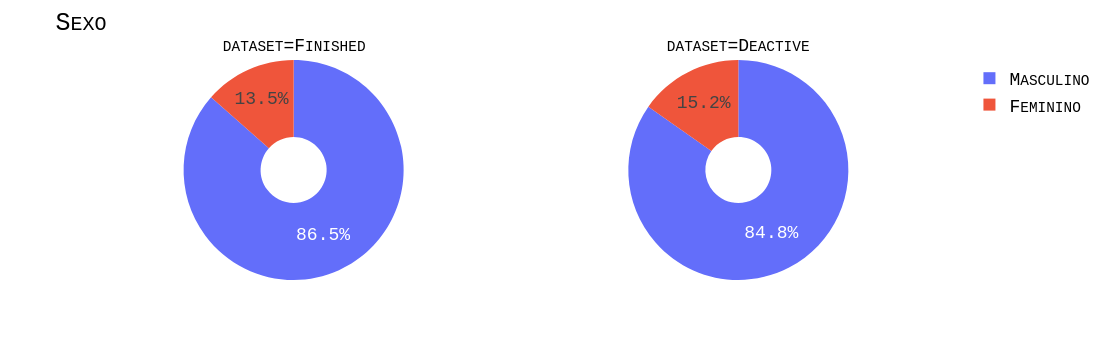

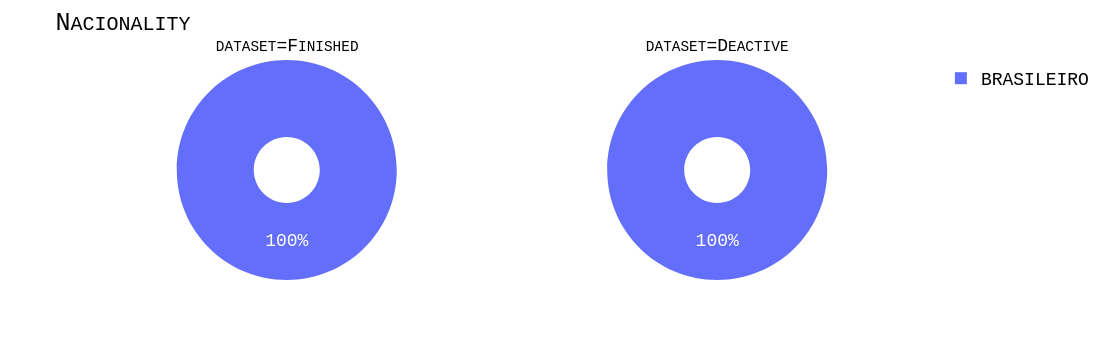

In [94]:
px.pie(
    x, 
    names='Tipo ingresso', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Application "},font=my_font).show()

px.pie(
    x, 
    names='Raça', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Ethinic "},font=my_font).show()


px.pie(
    x, 
    names='Sexo', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Sexo "},font=my_font).show()


px.pie(
    x, 
    names='Nacionalidade', 
    facet_col='dataset', 
    hole=0.3,
).update_layout(title={"text": "Nacionality "},font=my_font).show()

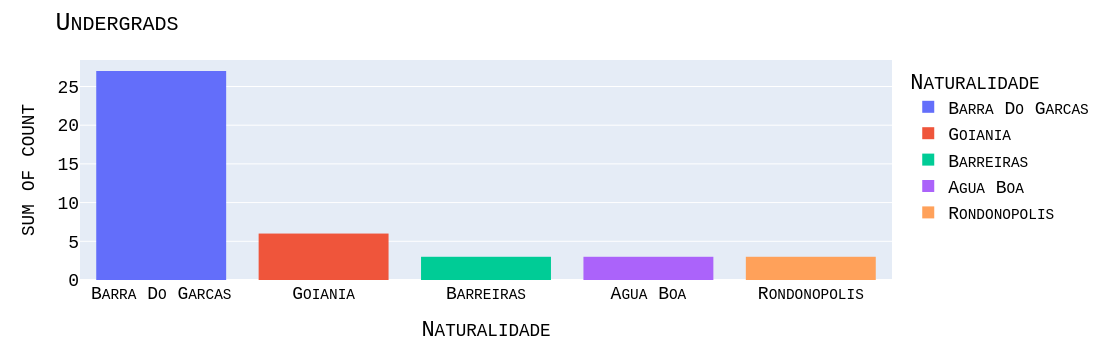

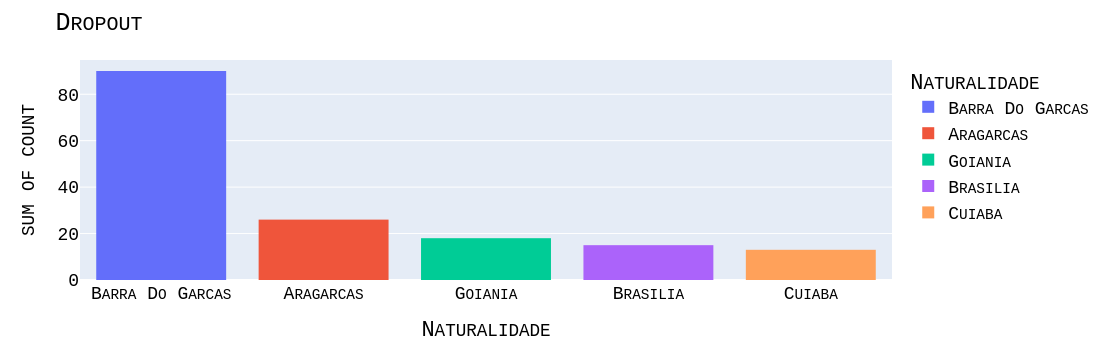

In [95]:
x_grouped =  finished.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.histogram(x_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Undergrads"}, font=my_font).show()
px.histogram(y_grouped.head(), x='Naturalidade', y='count', color='Naturalidade').update_layout(title={"text": "Dropout"}, font=my_font).show()


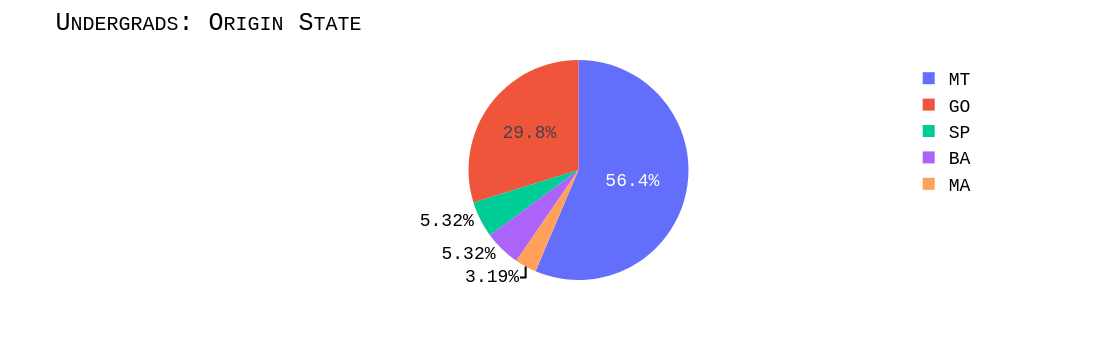

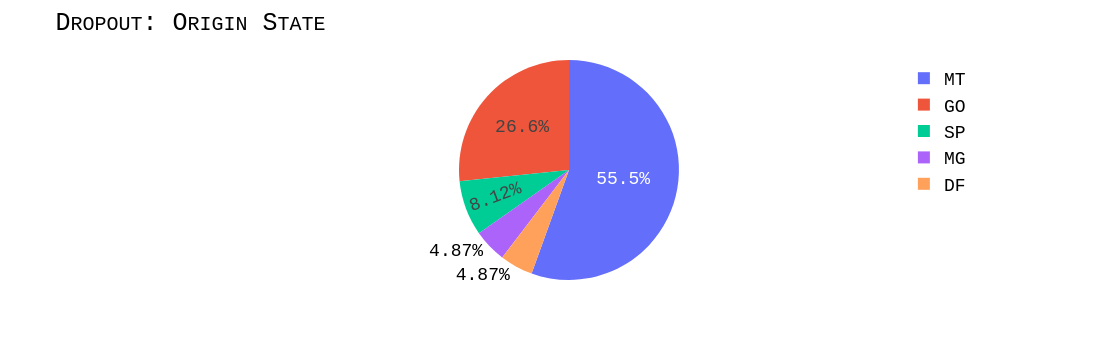

In [154]:
x_grouped =  finished.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y_grouped =  dropout.groupby(['UF Naturalidade']).size().reset_index(name='count').sort_values(by='count', ascending=False)
px.pie(x_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Undergrads: Origin State"}, font=my_font).show()
px.pie(y_grouped.head(), names='UF Naturalidade', values='count', color='UF Naturalidade').update_layout(title={"text": "Dropout: Origin State"}, font=my_font).show()


## Analysing the years of entrance

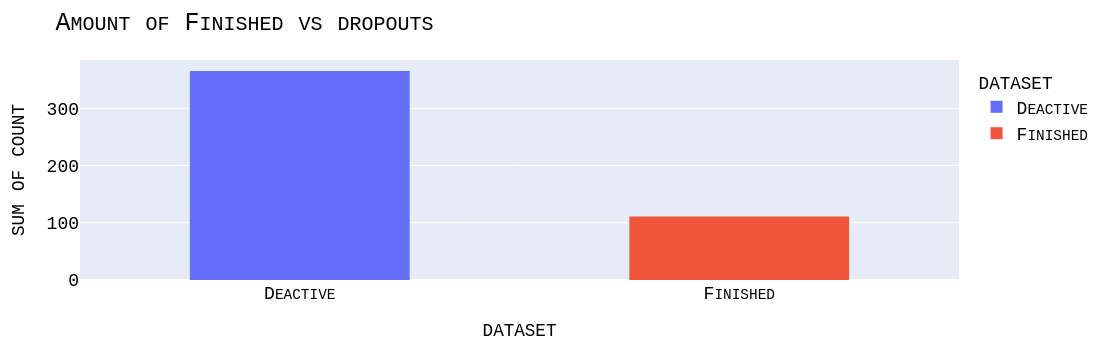

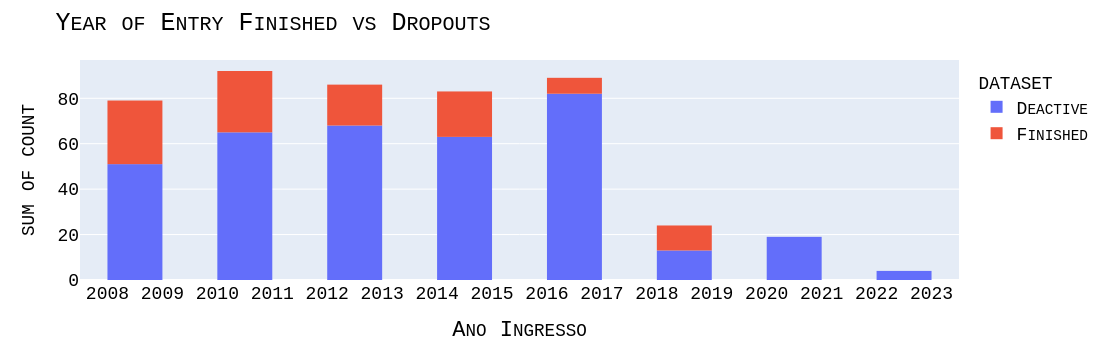

In [315]:
x = pd.concat([
        finished.assign(dataset="Finished"),
        dropout.assign(dataset="Deactive")])

test = x.copy()
# extracting the year of entrance
test = test[test['Período ingresso'] != 0]  # removing those with Período de Ingresso too high

test['Ano Ingresso'] = (test['Período ingresso'] / 10).astype("int")

x['Ano Ingresso'] = test['Ano Ingresso']

y = x.groupby(['Ano Ingresso', 'Sexo', 'dataset']).size().reset_index(name='count').sort_values(by='count', ascending=False)
y = y[y['Ano Ingresso'] != 0] # making sure there are not the 22 zero values messing up the plot 
px.histogram(y, x='dataset', y='count', color='dataset').update_layout(bargap=0.5).update_layout(bargap=0.5, title={"text": "Amount of Finished vs dropouts"}, font=my_font).show()
px.histogram(y, x='Ano Ingresso', y='count', color='dataset').update_layout(bargap=0.5, title={"text": "Year of Entry Finished vs Dropouts"}, font=my_font).update_xaxes(tickmode='linear',dtick=1).show()


## Average time which someone evades

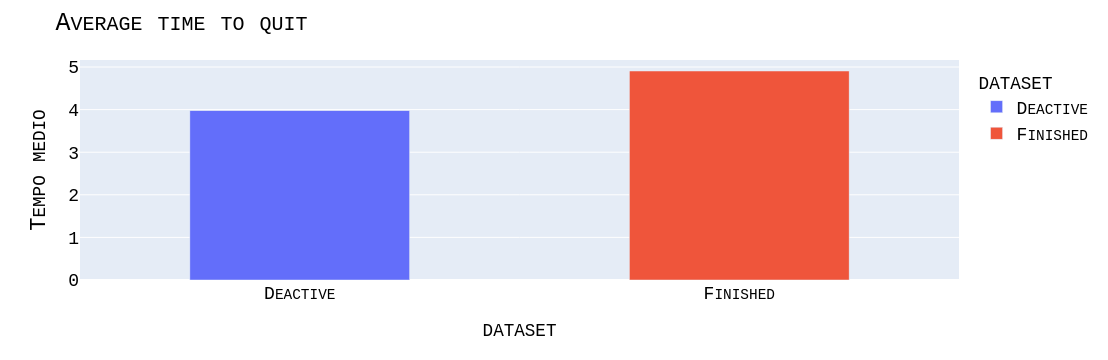

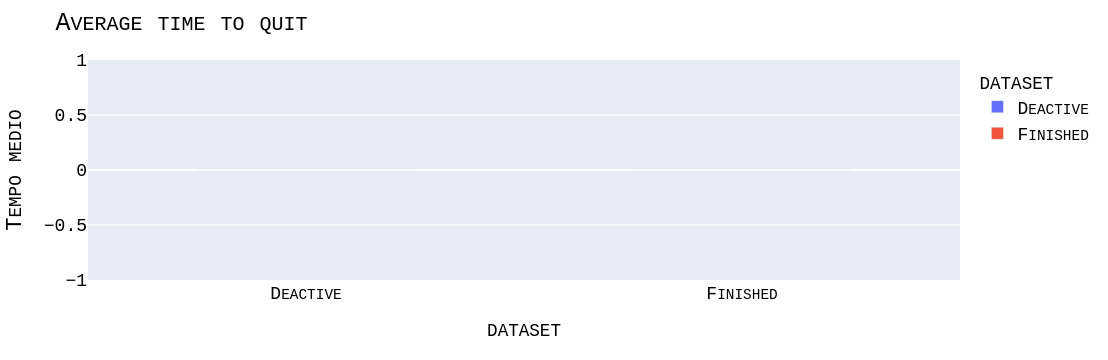

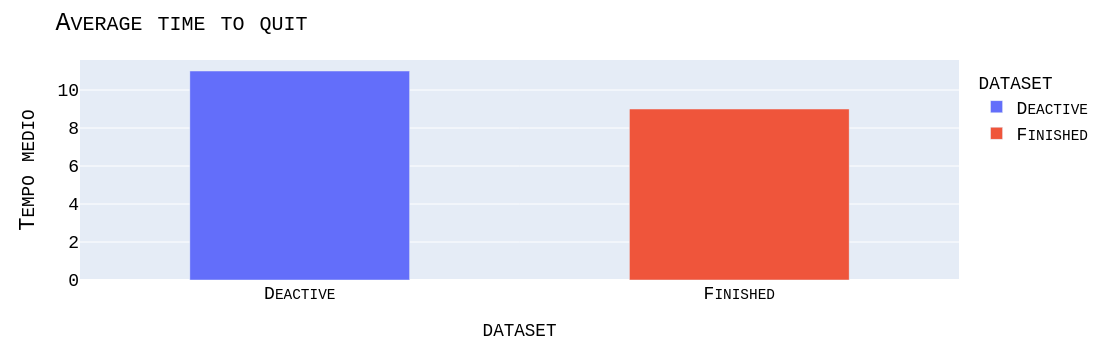

In [348]:
# let us do the math: If we subtract the period the person entered with the current period of the person, 
# we can get how much time they have spent in college 
test = test.dropna(subset=['Data ocorrência'])

test['Ano atual']  = np.where (
    test['Data ocorrência'].isnull(),
    (test['Período'] /10), 
     test['Data ocorrência'].str[:4].astype(float)) 
test['Ano atual'] = test['Ano atual'].fillna(0).astype(int)

test['Tempo medio'] = test['Ano atual'] - test['Ano Ingresso']

mean_time = test.groupby('dataset')['Tempo medio'].mean().reset_index()
min_time = test.groupby('dataset')['Tempo medio'].min().reset_index()
max_time = test.groupby('dataset')['Tempo medio'].max().reset_index()
median_time = test.groupby('dataset')['Tempo medio'].median().reset_index()


px.bar(mean_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Average time to quit"}, font=my_font).show()
px.bar(min_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Average time to quit"}, font=my_font).show()
px.bar(max_time, x='dataset', y='Tempo medio', color='dataset').update_layout(bargap=0.5, title={"text": "Average time to quit"}, font=my_font).show()
